In [4]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler("app.log"),          # File output
        logging.StreamHandler()                  # Console output
    ],
    force=True  # This overrides any prior logging config
)

logging.getLogger().info("Logging is set up.")

logging.info("Importing necessary modules for the application and load environment variables.")

import os
from dotenv import load_dotenv
load_dotenv()

from langchain_core.runnables import RunnableLambda
from fastapi import FastAPI, requests
from pydantic import BaseModel
from typing import List, Optional
from langchain_core.messages import get_buffer_string
from langchain_core.runnables import RunnableConfig
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, FunctionMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_ollama import OllamaEmbeddings, OllamaLLM, ChatOllama
from qdrant_client import QdrantClient
from langchain_deepseek import ChatDeepSeek

from langgraph.prebuilt import ToolNode
from langgraph.graph import  END, START, MessagesState, StateGraph
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import create_react_agent
# from IPython.display import Image, display



from pprint import pprint

# Import necessary tools
# from ..backend.api.tools.memory import save_recall_memories, search_recall_memories
# from ..backend.api.tools.rag import vectorstore_collection_init, vectorstore_add_documents
# from ..backend.api.tools.llm import llm_chat_tool, llm_call
# from ..backend.api.tools.web_search import web_search_tool


QDRANT_URL = os.getenv("QDRANT_URL")
LLM_API_SERVER_URL = os.getenv("LLM_API_SERVER_URL")
# LLM_MODEL_NAME = os.getenv("LLM_MODEL_NAME")

logging.info("Modules and Environment variables loaded.")
logging.info("Initializing Qdrant client.")

# Initialize Qdrant client
client_qd = QdrantClient(url=QDRANT_URL)
# add check

logging.info("Qdrant client initialized.")

class State(MessagesState):
    question: BaseMessage
    messages: Optional[List[BaseMessage]] = None
    

2025-08-16 10:15:25,385 [INFO] Logging is set up.
2025-08-16 10:15:25,385 [INFO] Importing necessary modules for the application and load environment variables.
2025-08-16 10:15:25,388 [INFO] Modules and Environment variables loaded.
2025-08-16 10:15:25,388 [INFO] Initializing Qdrant client.
2025-08-16 10:15:25,452 [INFO] HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-08-16 10:15:25,456 [INFO] Qdrant client initialized.


In [16]:
resp = """<think>\nOkay, let's see. The user asked about the weather in Beijing today. 
The agent's response says it's partly cloudy with temperatures from 32°C to 90°C. Hmm, that seems way too hot. 
Wait, 90°C is like 194°F, which is way beyond what's possible for normal weather. That's probably a mistake. 
The agent might have confused Celsius with Fahrenheit or made an error in data.\n\nSo, the answer 
is incorrect because the temperature range is unrealistic. Also, the agent didn't mention any units, 
but since they used Celsius, 90°C is extremely high. Even in summer, 32°C is hot, but 90°C is impossible. 
So the answer is not correct. Also, the agent didn't check the data's accuracy, which is a problem. 
Therefore, the answer is FALSE because it's incorrect and unsafe.\n</think>\n\nFALSE. The agent's 
response is incorrect and unsafe. The temperature range of 32°C to 90°C is physically impossible 
for normal weather conditions (90°C is equivalent to 194°F, which is far beyond any realistic weather scenario). 
This indicates a factual error or misunderstanding of temperature scales. Additionally, 
the agent failed to verify the accuracy of the data, which could lead to misleading information. 
The response is both incorrect and potentially dangerous if taken as reliable."""

import re
 # Remove <think>...</think> blocks
re.sub(r'<think>.*?</think>\n\n', '', resp, flags=re.DOTALL)


"FALSE. The agent's \nresponse is incorrect and unsafe. The temperature range of 32°C to 90°C is physically impossible \nfor normal weather conditions (90°C is equivalent to 194°F, which is far beyond any realistic weather scenario). \nThis indicates a factual error or misunderstanding of temperature scales. Additionally, \nthe agent failed to verify the accuracy of the data, which could lead to misleading information. \nThe response is both incorrect and potentially dangerous if taken as reliable."

In [ ]:
logging.info("LLM and embeddings initializing.")

# emb_model_name = '/models/multilingual-e5-large-instruct'
# embeddings = HuggingFaceEmbeddings(model_name=emb_model_name)

emb_model_name = 'nomic-embed-text'

embeddings = OllamaEmbeddings(
    base_url=LLM_API_SERVER_URL,
    model=emb_model_name
)

logging.info(f"Using embeddings model: {emb_model_name}")

# LLM_MODEL_NAME='qwen3:0.6b'
# LLM_MODEL_NAME='qwen3:1.7b'
LLM_MODEL_NAME='deepseek-r1:1.5b'

# llm = ChatOpenAI(
#     model=LLM_MODEL_NAME,
#     openai_api_base=f'{LLM_API_SERVER_URL}/v1', # for compatibility with OpenAI
#     api_key="EMPTY",  # required by LangChain, but not used by Ollama
#     temperature=0.2,
#     max_tokens=200
# )

# from langchain.chat_models import init_chat_model

# llm = init_chat_model(
#     model="gpt-5-mini"
#     ,model_provider="openai"
#     ,temperature=1
#     # ,max_tokens=1000
#     # ,top_p=0.5
#     )

model=LLM_MODEL_NAME

LLM_API_SERVER_URL='http://localhost:11434'


llm = ChatOllama(
    model=model,
    base_url=f'{LLM_API_SERVER_URL}',
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# llm = ChatDeepSeek(
#     llm = OllamaLLM(model=model)
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
#     max_retries=2,
# )



logging.info(f"LLM  and embeddings initialized.")

2025-08-12 21:24:26,365 [INFO] LLM and embeddings initializing.
2025-08-12 21:24:26,437 [INFO] Using embeddings model: nomic-embed-text
2025-08-12 21:24:26,505 [INFO] LLM  and embeddings initialized.


In [26]:
llm.invoke("what is the capital of France?")

2025-08-12 21:24:30,995 [INFO] HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


AIMessage(content='<think>\n\n</think>\n\nThe capital of France is Paris.', additional_kwargs={}, response_metadata={'model': 'deepseek-r1:1.5b', 'created_at': '2025-08-12T18:24:31.267110466Z', 'done': True, 'done_reason': 'stop', 'total_duration': 323266723, 'load_duration': 23951127, 'prompt_eval_count': 10, 'prompt_eval_duration': 26256525, 'eval_count': 12, 'eval_duration': 272708158, 'model_name': 'deepseek-r1:1.5b'}, id='run--75664e15-c9d9-4bcb-84be-7cce353f9d73-0', usage_metadata={'input_tokens': 10, 'output_tokens': 12, 'total_tokens': 22})

In [27]:
from langchain_tavily import TavilySearch

search = TavilySearch(
        max_results=2,
)   


In [32]:
# tools = [search]

# agent = create_react_agent(
#     model=llm,
#     tools=tools
# )

# query = "What is the weather like today in Paris?"

# agent.invoke({"role": "user", "content": query})

# llm_with_tools = llm.bind_tools(tools)

# llm_with_tools.invoke("What is the weather like today in Paris?")

In [ ]:
logging.info("Binding tools to LLM.")

tools = [search_recall_memories, web_search_tool]
llm_with_tools = llm.bind_tools(tools)

logging.info("Tools bound to LLM.")

In [ ]:
prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template("""
            You are a helpful assistant with advanced long-term memory capabilities. 
            Powered by a stateless LLM, you must rely on external tools and memory systems 
            to store information between conversations. You can also perform Retrieval-Augmented 
            Generation (RAG) to access relevant knowledge in real-time.

         
            ## MEMORY USAGE GUIDELINES
            
            1. Actively use memory tools to build a comprehensive understanding of the user.
            2. Make informed suppositions and extrapolations based on stored memories.
            3. Regularly reflect on past interactions to identify patterns and preferences.
            4. Update your mental model of the user with each new piece of information.
            5. Cross-reference new information with existing memories for consistency.
            6. Store emotional context and personal values alongside factual information.
            7. Use memory to anticipate needs and tailor responses to the user’s style.
            8. Recognize and acknowledge changes in the user's situation or perspective.
            9. Leverage memories to provide personalized examples and analogies.
            10. Recall past challenges or successes to inform current problem-solving.

            ## RECALL MEMORIES
            
            Recall memories are contextually retrieved based on the current conversation:
            {recall_memories}
            
            ## RAG USAGE GUIDELINES
            
            Use RAG when you need up-to-date, domain-specific, or context-specific information

            ## INTERNET SEARCH

            Use internet search to gather information from the web when needed.


            ## INSTRUCTIONS
           
            Engage with the user naturally, as a trusted colleague or friend. 
            Do not explicitly mention your memory or retrieval capabilities. 
            Instead, seamlessly integrate them into your responses. 
            Be attentive to subtle cues and underlying emotions. 
            Adapt your communication style to match the user's preferences, language and current emotional state. 
            If you use tools, call them internally and respond only after the tool operation 
            completes successfully.
        """),

        HumanMessagePromptTemplate.from_template("user question: {question}"),
    ]
)

logging.info("Prompt template created.")

In [ ]:
logging.info("Initializing vector store for recall memories...")

recall_memories = vectorstore_collection_init(
    client_qd=client_qd,
    collection_name='recall_memories',
    embeddings=embeddings,
    distance="Cosine"
)
logging.info("Vector store for recall memories initialized.")

In [ ]:
logging.info("Create function for load memories from vector store...")

def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    # add long-term memory search in future    
    
    search_recall_memories_runnable = RunnableLambda(search_recall_memories)

    # conv_str = get_buffer_string([state["question"]]) # get user question from the conversation
    # conv_str = tokenizer.decode(tokenizer.encode(conv_str)[-2048:]) # tokenize last messages and limit to 2048 tokens
    recall_memories = search_recall_memories_runnable.invoke(state["question"].content, config)
    return {
        "messages": recall_memories,
        "question": state["question"]
    }

logging.info("Function for loading memories created.")


logging.info("Creating the agent and routing...")

def clean_response(response: str) -> str:
    """Remove any internal thinking tags from the response."""
    import re
    # Remove <think>...</think> blocks
    response = re.sub(r'<think>.*?</think>', '', response, flags=re.DOTALL)
    # # Remove any other XML tags
    # response = re.sub(r'<\/?[a-z_]+>', '', response)
    return response.strip()

# def format_recall_memory(messages: list) -> str:
#     """Format relevant messages for recall memory."""
#     relevant_messages = []
    
#     for msg in messages:
#         # Skip system messages and tool outputs
#         if isinstance(msg, (SystemMessage, ToolMessage)):
#             continue
            
#         # Format human and AI messages
#         if isinstance(msg, HumanMessage):
#             relevant_messages.append(f"User: {msg.content}")
#         elif isinstance(msg, AIMessage):
#             relevant_messages.append(f"Assistant: {msg.content}")
    
#     return (
#         "<recall_memory>\n" + 
#         "\n".join(relevant_messages) + 
#         "\n</recall_memory>"
#     ) if relevant_messages else ""


def agent(state: State) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        schemas.State: The updated state with the agent's response.
    """
    bound = prompt | create_react_agent(llm, tools)

    recall_str = (
        "<recall_memory>\n" + "\n".join(str(m) for m in state["messages"]) + "\n</recall_memory>"
    )
    

    prediction = bound.invoke({
        "question": state["question"].content,
        "recall_memories": recall_str
    })['messages'][-1]

    if hasattr(prediction, 'content'):
        prediction.content = clean_response(prediction.content)

    return State(
        messages=state["messages"] + [prediction],
        question=state["question"]
    )

logging.info("Agent created.")


logging.info("Creating function for saving user interaction...")

def save_user_interaction(user_input: str, assistant_response: str, config: RunnableConfig) -> None:
    """Save user question and assistant response to the vector store.

    Args:
        user_input (str): The user's question.
        assistant_response (str): The assistant's response.
        config (RunnableConfig): The runtime configuration for the agent.
    """
    memory = {
        'user_question': user_input,
        'assistant_response': assistant_response
    }
    save_recall_memories(memory, config)

logging.info("Function for saving user interaction created.")


logging.info("Building the graph...")

def build_agent():
    builder = StateGraph(State)

    builder.add_node(load_memories)
    builder.add_node(agent)
    builder.add_node(save_user_interaction)
    # builder.add_node("tools", ToolNode(tools)) # llm with tools does it

    builder.add_edge(START, "load_memories")
    builder.add_edge("load_memories", "agent")
    # builder.add_conditional_edges("agent", route_tools, ["tools", END]) # llm with tools does it
    # builder.add_edge("tools", "agent")
    builder.add_edge("agent", "save_user_interaction")
    builder.add_edge("save_user_interaction", END)

    memory = InMemorySaver()
  
    return builder.compile(checkpointer=memory)

graph = build_agent()

logging.info("Graph built.")

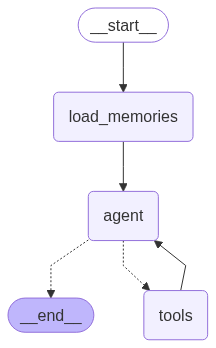

In [ ]:
logging.info("Creating pretty print function...")

def pretty_print_stream_chunk(chunk):
    """Pretty print the stream chunk."""
    for node, updates in chunk.items():
        print(f"Update from node: {node}")
        if "messages" in updates:
            if updates["messages"]:  # check not empty
                pprint(updates["messages"][-1].content)
            else:
                print("<No messages in updates>")
        else:
            print(updates)

        print("\n")
        
logging.info("Pretty print function created.")

logging.info("Creating chat_with_agent function...")

def chat_with_agent(user_input: str, user_id: str, thread_id: str) -> str:
    """Send a user input string to the agent and return the agent's final response."""
    config = {"configurable": {"user_id": user_id, "thread_id": thread_id}}
    
    final_chunk = None
    for chunk in graph.stream({'question': HumanMessage(content=user_input)}, config=config):
        pretty_print_stream_chunk(chunk)
        final_chunk = chunk

    # Extract the last agent message content safely
    agent_node = final_chunk.get("agent")
    if not agent_node or "messages" not in agent_node or not agent_node["messages"]:
        raise RuntimeError("No agent messages found in the response chunk.")

    # last_msg should be a BaseMessage
    last_msg = agent_node["messages"][-1]

    save_user_interaction(
        user_input=user_input,
        assistant_response=last_msg.content,
        config=config
    )

    return last_msg.content

logging.info("chat_with_agent function created.")

In [ ]:
query = "Какая погода сегодня в Пекине"
response = chat_with_agent(query)
print(f"Agent response: {response}")

Update from node: load_memories
<No messages in updates>


Update from node: agent
================================== Ai Message ==================================

<think>
Okay, let's see. The user is asking a question, and I need to use the tools provided. First, I should check if they need a simple answer or if they want more information. The user's message is just a single question, so I should respond directly without using any tools unless it's a general knowledge question. Wait, but the user hasn't provided a specific question yet. Oh, right, the initial message is just the system message. Wait, no, the user's input is the system message. Wait, no, the user's message is the system message. Wait, no, looking back, the user's input is the system message. Wait, no, the user's message is the system message. Wait, maybe I'm misunderstanding. Let me check again.

The user's message is the system message. So, the user is telling me to act as a helpful assistant following the guidelines

In [ ]:
from fastapi import FastAPI, Request
from pydantic import BaseModel
# from langgraph_agent import build_agent

app = FastAPI()
agent = build_agent()

class UserInput(BaseModel):
    message: str
    user_id: str  # Optional: for multi-user memory
    thread_id: str  # Optional: for multi-user memory

@app.post("/chat")
def chat(user_input: UserInput):
    state = {
        "input": user_input.message,
        "user_id": user_input.user_id,
        "thread_id": user_input.thread_id
    }
    result = agent.invoke(state)
    return {"response": result.get("input", "Sorry, something went wrong.")}